# 蒸汽预测比赛
____________________
**tip:在做lasso选择特征的时候没有归一化处理，导致特征选择出错**

### 导入要使用到的包

In [8]:
%matplotlib inline
import pandas as pd
import numpy as np
import lightgbm as lgb
import warnings
import matplotlib.pylab as plt
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor 
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.grid_search import GridSearchCV
from sklearn import cross_validation, metrics
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error
warnings.filterwarnings("ignore")

### 准备训练集数据

In [46]:
df_train = pd.read_csv('./zhengqi_train.txt',sep='\t')
df_test = pd.read_csv('./zhengqi_test.txt',sep='\t')

In [47]:
Y_data = df_train['target']
X_data = df_train.drop('target',axis=1)
x_train,x_test,y_train,y_test = train_test_split(X_data,Y_data,train_size = 0.7)

### 先用LassoCV做个特征选择

In [52]:
ls = LassoCV(cv=5,eps=0.0002)
ls.fit(x_train,y_train)
mean_squared_error(y_test,ls.predict(x_test))

0.10602643811465329

In [49]:
def Feature_delete(coef_,feature_name):
    select = []
    for i,feature_name in zip(coef_,feature_name):
        if i == 0:
            select.append(feature_name)
        else:
            pass
    return select

### 丢弃的特征 

In [53]:
Fd = Feature_delete(ls.coef_,x_train.columns)
Fd

['V13', 'V16', 'V31']

In [16]:
new_df = X_data.drop(Fd,axis=1)
new_df.head()

,V0,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V27,V28,V29,V30,V32,V33,V34,V35,V36,V37
0,0.566,0.016,-0.143,0.407,0.452,-0.901,-1.812,-2.360,-0.436,-2.114,...,0.168,-0.450,0.136,0.109,0.327,-4.627,-4.789,-5.101,-2.608,-3.508
1,0.968,0.437,0.066,0.566,0.194,-0.893,-1.566,-2.360,0.332,-2.114,...,0.338,0.671,-0.128,0.124,0.600,-0.843,0.160,0.364,-0.335,-0.730
2,1.013,0.568,0.235,0.370,0.112,-0.797,-1.367,-2.360,0.396,-2.114,...,0.326,1.287,-0.009,0.361,-0.116,-0.843,0.160,0.364,0.765,-0.589
3,0.733,0.368,0.283,0.165,0.599,-0.679,-1.200,-2.086,0.403,-2.114,...,0.277,1.298,0.015,0.417,0.603,-0.843,-0.065,0.364,0.333,-0.112
4,0.684,0.638,0.260,0.209,0.337,-0.454,-1.073,-2.086,0.314,-2.114,...,0.332,1.289,0.183,1.078,0.418,-0.843,-0.215,0.364,-0.280,-0.028


### 特征选择后模型的MSE有点提高

In [18]:
x1_train,x1_test,y1_train,y1_test = train_test_split(new_df,Y_data,train_size = 0.8)
ls = LassoCV(cv=5,eps=0.02)
ls.fit(x1_train,y1_train)
mean_squared_error(y1_test,ls.predict(x1_test))

0.11076154642526383

### Kmeans聚类分析，簇多一点方便检测离群点

In [19]:
kmodel = KMeans(n_clusters = 10, n_jobs = 2) #K=9聚类
kmodel.fit(new_df) 
new_df['label'] = kmodel.labels_  
s = new_df['label'].value_counts().index[-1]
print(s)
t = new_df['label'].value_counts()
ls = t.values[-1]
print(ls)

7
54


**聚类检测离群点并返回剔除后结果**

In [21]:
def drop_bad_data(df_,k=10):
    k_model_ = KMeans(n_clusters = k, n_jobs = 2).fit(df_)
    df_['label'] = k_model_.labels_
    bad_label = df_['label'].value_counts().index[-1]
    delete_n = df_['label'].value_counts().values[-1]
    total_n = df_.shape[0]
    print('Delete: %.f data,Percentage %.4f'%(delete_n,delete_n/total_n))
    dbd_df = df_[df_['label'] != bad_label]
    return dbd_df.drop('label',axis=1)

new_df_x = drop_bad_data(new_df,10)

Delete: 31 data,Percentage 0.0107


### 丢弃数量少的簇（离群数据）

In [22]:
#new_df_x = new_df[new_df['label'] != 6].drop('label',axis=1)
new_df_y = Y_data.reindex(index = new_df_x.index)

### 从LassoCV的MSE来说，测试集数据又更纯洁了一点 

In [23]:
x2_train,x2_test,y2_train,y2_test = train_test_split(new_df_x,new_df_y,train_size = 0.7)
ls = LassoCV(cv=5,eps=0.02)
ls.fit(x2_train,y2_train)
mean_squared_error(y2_test,ls.predict(x2_test))

0.10981434307215636

### RandomForest模型

In [30]:
rf0 = RandomForestRegressor(oob_score=True, random_state=10) #obb_score=True 即是否采用袋外样本来评估模型的好坏,默认FALSE
rf0.fit(x2_train,y2_train)
mean_squared_error(y2_test,rf0.predict(x2_test))

0.145230880786385

In [31]:
param_test1 = {'n_estimators':[10,20,30,40,50,60,70]}
gsearch1 = GridSearchCV(estimator = RandomForestRegressor(min_samples_split=100,
                                  min_samples_leaf=20,max_depth=8,max_features='sqrt' ,random_state=10), 
                       param_grid = param_test1, scoring='neg_mean_squared_error',cv=5)
gsearch1.fit(x2_train,y2_train)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: -0.17710, std: 0.01462, params: {'n_estimators': 10},
  mean: -0.17149, std: 0.01572, params: {'n_estimators': 20},
  mean: -0.16513, std: 0.01606, params: {'n_estimators': 30},
  mean: -0.16129, std: 0.01364, params: {'n_estimators': 40},
  mean: -0.16114, std: 0.01323, params: {'n_estimators': 50},
  mean: -0.16117, std: 0.01282, params: {'n_estimators': 60},
  mean: -0.16231, std: 0.01252, params: {'n_estimators': 70}],
 {'n_estimators': 50},
 -0.1611420647928479)

In [14]:
param_test2 = {'max_depth':[13,15,17,20], 'min_samples_split':[20,40,60,80]}
gsearch2 = GridSearchCV(estimator = RandomForestRegressor(n_estimators= 50, 
                                  min_samples_leaf=20,max_features='sqrt' ,oob_score=True, random_state=10),
                        param_grid = param_test2,scoring='neg_mean_squared_error',cv=5)
gsearch2.fit(x2_train,y2_train)
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: -0.16382, std: 0.01804, params: {'max_depth': 13, 'min_samples_split': 20},
  mean: -0.16382, std: 0.01804, params: {'max_depth': 13, 'min_samples_split': 40},
  mean: -0.17339, std: 0.01825, params: {'max_depth': 13, 'min_samples_split': 60},
  mean: -0.17854, std: 0.01908, params: {'max_depth': 13, 'min_samples_split': 80},
  mean: -0.16382, std: 0.01804, params: {'max_depth': 15, 'min_samples_split': 20},
  mean: -0.16382, std: 0.01804, params: {'max_depth': 15, 'min_samples_split': 40},
  mean: -0.17339, std: 0.01825, params: {'max_depth': 15, 'min_samples_split': 60},
  mean: -0.17854, std: 0.01908, params: {'max_depth': 15, 'min_samples_split': 80},
  mean: -0.16382, std: 0.01804, params: {'max_depth': 17, 'min_samples_split': 20},
  mean: -0.16382, std: 0.01804, params: {'max_depth': 17, 'min_samples_split': 40},
  mean: -0.17339, std: 0.01825, params: {'max_depth': 17, 'min_samples_split': 60},
  mean: -0.17854, std: 0.01908, params: {'max_depth': 17, 'min_samples_split

In [15]:
rf1 = RandomForestRegressor(n_estimators= 50, max_depth=13, min_samples_split=20,
                                  min_samples_leaf=20,max_features='sqrt' ,oob_score=True, random_state=10)
rf1.fit(x2_train,y2_train)
mean_squared_error(y2_test,rf1.predict(x2_test))

0.1395547141609921

In [16]:
param_test3 = {'min_samples_leaf':[10,20,30,40,50]}
gsearch3 = GridSearchCV(estimator = RandomForestRegressor(n_estimators= 50, max_depth=13,min_samples_split=20,
                                  max_features='sqrt' ,oob_score=True, random_state=10),
   param_grid = param_test3, scoring='neg_mean_squared_error',iid=False, cv=5)
gsearch3.fit(x2_train,y2_train)
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: -0.14932, std: 0.01790, params: {'min_samples_leaf': 10},
  mean: -0.16380, std: 0.01804, params: {'min_samples_leaf': 20},
  mean: -0.17879, std: 0.01759, params: {'min_samples_leaf': 30},
  mean: -0.18914, std: 0.01660, params: {'min_samples_leaf': 40},
  mean: -0.20636, std: 0.01833, params: {'min_samples_leaf': 50}],
 {'min_samples_leaf': 10},
 -0.14931921457736444)

In [17]:
rf2 = RandomForestRegressor(n_estimators= 50, max_depth=13, min_samples_split=20,
                                  min_samples_leaf=10,max_features='sqrt' ,oob_score=True, random_state=10)
rf2.fit(x2_train,y2_train)
mean_squared_error(y2_test,rf2.predict(x2_test))

0.12802584242669934

In [18]:
param_test4 = {'max_features':[4,5,6,7,8,9]}
gsearch4 = GridSearchCV(estimator = RandomForestRegressor(n_estimators= 50, max_depth=13, min_samples_split=20,
                                  min_samples_leaf=10 ,oob_score=True, random_state=10),
   param_grid = param_test4, scoring='neg_mean_squared_error',iid=False, cv=5)
gsearch4.fit(x2_train,y2_train)
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

([mean: -0.14616, std: 0.01528, params: {'max_features': 4},
  mean: -0.14496, std: 0.01764, params: {'max_features': 5},
  mean: -0.14505, std: 0.01736, params: {'max_features': 6},
  mean: -0.14652, std: 0.01935, params: {'max_features': 7},
  mean: -0.14731, std: 0.01871, params: {'max_features': 8},
  mean: -0.14757, std: 0.01940, params: {'max_features': 9}],
 {'max_features': 5},
 -0.14496280950823384)

### RandomForest模型 

In [25]:
rf3 = RandomForestRegressor(n_estimators= 50, max_depth=13, min_samples_split=20,
                                  min_samples_leaf=10,max_features=7 ,oob_score=True, random_state=10)
rf3.fit(x2_train,y2_train)
mean_squared_error(y2_test,rf3.predict(x2_test))

0.12145516357047532

### AdaBoost模型
**AdaBoost调参一样用GridSerchCV调参**

In [26]:
bdt = AdaBoostRegressor(DecisionTreeRegressor(max_depth=25, min_samples_split=50, min_samples_leaf=20,criterion='mse'),loss='square',
                         n_estimators=100, learning_rate=0.6)
bdt.fit(x2_train, y2_train)
mean_squared_error(y2_test,bdt.predict(x2_test))

0.11578447284711015

### GBDT模型
**GBDT模型调参也是一样的**

In [27]:
gbm = GradientBoostingRegressor(learning_rate=0.2, n_estimators=80,max_depth=13, min_samples_leaf =60, 
                                min_samples_split =800, max_features='sqrt', subsample=0.9, random_state=10)

gbm.fit(x2_train,y2_train)
mean_squared_error(y2_test,gbm.predict(x2_test))

0.11473343792382075

### LightGBM模型
**LGB模型调参也是一样的**

In [28]:
lgb_model = lgb.LGBMModel(boosting_type='gbdt', num_leaves=35, max_depth=20, max_bin=255, learning_rate=0.03,n_estimator=10,
                                                   subsample_for_bin=200000, objective='regression', min_split_gain=0.0, 
                                                   min_child_weight=0.001, min_child_samples=20, subsample=1.0, verbose= 0,
                                                   subsample_freq=1, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0,
                                                   random_state=None, n_jobs=-1, silent=True)

lgb_model.fit(x2_train,y2_train)
mean_squared_error(y2_test,lgb_model.predict(x2_test))

0.11288872840905767

### 准备预测数据

In [78]:
x2_train.columns
df_test_fit = df_test[x2_train.columns]
df_test_fit.head()

,V0,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V27,V28,V29,V30,V32,V33,V34,V35,V36,V37
0,0.368,0.380,-0.225,-0.049,0.379,0.092,0.550,0.551,0.244,0.904,...,0.208,-0.449,0.047,0.057,0.847,0.534,-0.009,-0.190,-0.567,0.388
1,0.148,0.489,-0.247,-0.049,0.122,-0.201,0.487,0.493,-0.127,0.904,...,0.226,-0.443,0.047,0.560,0.551,0.046,-0.220,0.008,-0.294,0.104
2,-0.166,-0.062,-0.311,0.046,-0.055,0.063,0.485,0.493,-0.227,0.904,...,0.084,-0.458,-0.398,0.101,0.634,0.017,-0.234,0.008,0.373,0.569
3,0.102,0.294,-0.259,0.051,-0.183,0.148,0.474,0.504,0.010,0.904,...,0.203,-0.456,-0.398,1.007,1.042,-0.040,-0.290,0.008,-0.666,0.391
4,0.300,0.428,0.208,0.051,-0.033,0.116,0.408,0.497,0.155,0.904,...,0.227,-0.458,-0.776,0.291,0.181,-0.040,-0.290,0.008,-0.140,-0.497


In [101]:
result = pd.DataFrame()
result['rf'] = rf3.predict(df_test_fit)
result['adaboost'] = bdt.predict(df_test_fit)
result['gbdt'] = gbm.predict(df_test_fit)
result['lightgbm'] = lgb_model.predict(df_test_fit)

### Stacking方法对集成学习再做训练 

In [109]:
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_absolute_error
result1 = pd.DataFrame()
result1['rf'] = rf3.predict(x2_train)
result1['adaboost'] = bdt.predict(x2_train)
result1['gbdt'] = gbm.predict(x2_train)
result1['lightgbm'] = lgb_model.predict(x2_train)
ls2 = RidgeCV(cv=5).fit(result1,y2_train)
coefs = ls2.coef_
intercepts = ls2.intercept_
mean_squared_error(y2_train,ls2.predict(result1))

0.03776383884478571

### 画图看看预测结果相互之间差距大不大 

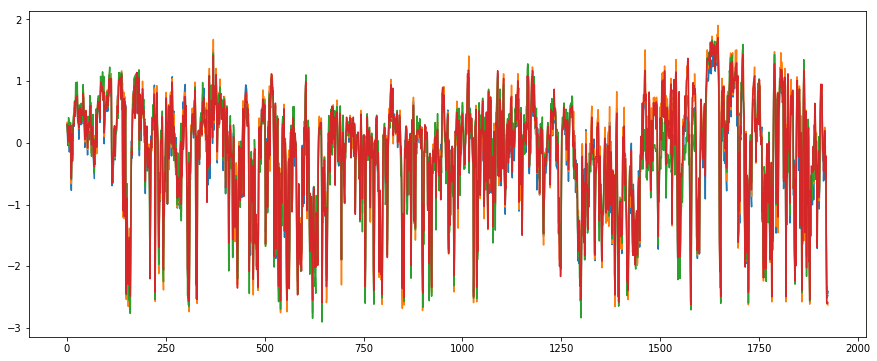

In [31]:
plt.figure(figsize=(15,6))
plt.plot(result)

### 以四个模型加上Stacking后的结果为最终结果

In [110]:
final = (result*coefs).apply(lambda x: x.sum(), axis=1) + intercepts
np.savetxt('final_stacking.txt',final)

In [106]:
result.head()

,rf,adaboost,gbdt,lightgbm
0,0.299375,0.332433,0.281389,0.301615
1,0.217211,0.312615,0.177823,0.286995
2,-0.041929,0.119079,0.144796,0.045329
3,0.108301,0.133625,0.076269,0.180308
4,0.210868,0.323000,0.408912,0.271519


**看Stacking后的系数，结果显示Adaboost和lightGBM权重更大** 

In [116]:
print(coefs)
intercepts

[-0.56773917  0.80826305 -0.15141734  0.95718059]


-0.01443766649758886

## 总结：
**上面的模型做出来提交结果MSE在0.14左右，GBDT和LightGBM都是梯度提升树因此有点重复，而且用Lasso做特征选择得到的结果好像不怎么好？**

**模型主要的问题是容易过拟合，一旦过拟合结果就会特别差，Stacking可以很好的避免过拟合**

In [107]:
final[:5]

0    0.330382
1    0.362699
2    0.127078
3    0.193119
4    0.324890
dtype: float64

# Stacking_2
----------------------------
**天池比赛提交的是这个模型的结果，MSE=0.1222**

**Lasso RandomForest LightGBM SVR Ridge**

### 再次读取训练集数据

In [3]:
df_train = pd.read_csv('./zhengqi_train.txt',sep='\t')
Y_data = df_train['target']
X_data = df_train.drop('target',axis=1)
#x_train,x_test,y_train,y_test = train_test_split(X_data,Y_data,train_size = 0.7)

In [94]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

SS = StandardScaler()
MMS = MinMaxScaler()
X_data_SS = SS.fit_transform(X_data)
X_data_MMS = MMS.fit_transform(X_data)

In [4]:
bad_f = ['V5','V17','V28','V22','V11','V9','V27']
df_train = df_train.drop(bad_f,axis=1)

In [73]:
X_data2 = pd.DataFrame(X_data_MMS,columns = X_data.columns)

### 用相关系数挑选特征 

In [3]:
corr = df_train.corr()
corr['target']
def get_feature_corr(list_,feature,limit_corr):
    feature_ = []
    for i_,f_ in zip(list_,feature):
        if abs(i_) < limit_corr:
            feature_.append(f_)
        else:
            pass
    return feature_
    
g_f_c = get_feature_corr(corr['target'],df_train.columns,0.1)
g_f_c

['V14', 'V21', 'V25', 'V26', 'V32', 'V33', 'V34']

### 用方差挑选特征

In [4]:
std = X_data.std()
def get_feature_std(std,feature_name,limit_std):
    feature_ = []
    for i,j in zip(std,feature_name):
        if i < limit_std:
            feature_.append(j)
        else:
            pass
    return feature_

g_f_s = get_feature_std(std,df_train.columns,0.6)
g_f_s

['V5', 'V27']

### 用聚类剔除异常点

In [27]:
def drop_bad_data(df_,k=10):
    k_model_ = KMeans(n_clusters = k, n_jobs = 2).fit(df_)
    df_['label'] = k_model_.labels_
    bad_label = df_['label'].value_counts().index[-1]
    delete_n = df_['label'].value_counts().values[-1]
    total_n = df_.shape[0]
    print('Delete: %.f data,Percentage %.4f'%(delete_n,delete_n/total_n))
    dbd_df = df_[df_['label'] != bad_label]
    return dbd_df.drop('label',axis=1)

#df_train_new = drop_bad_data(df_train,k=10)
df_train_new = df_get

### 最后是用方差提取的特征，删除了V5,V27

In [45]:
import pandas as pd
import numpy as np
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_absolute_error
from sklearn.svm import SVR
from sklearn.linear_model import LassoCV
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_data2 = X_data.drop(g_f_s,axis=1)

x_train,x_test,y_train,y_test = train_test_split(X_data2,Y_data,train_size = 0.7,random_state=100)
#############################################
svr_ = SVR(kernel='rbf', degree=5, coef0=0.0, tol=0.01, C=1.0, epsilon=0.01, shrinking=True, cache_size=200, verbose=False, 
           max_iter=-1).fit(x_train,y_train)
print('svr：%f' % mean_squared_error(y_test,svr_.predict(x_test)))
#############################################
x_train,x_test,y_train,y_test = train_test_split(X_data2,Y_data,train_size = 0.7,random_state=100)
lgb_ = lgb.LGBMModel(boosting_type='gbdt', num_leaves=35, max_depth=20, max_bin=255, learning_rate=0.05,n_estimator=10,
                                                   subsample_for_bin=2000, objective='regression', min_split_gain=0.0, 
                                                   min_child_weight=0.001, min_child_samples=20, subsample=1.0, verbose= 0,
                                                   subsample_freq=1, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0,
                                                   random_state=81, n_jobs=-1, silent=True).fit(x_train,y_train)
print('lgb：%f' % mean_squared_error(y_test,lgb_.predict(x_test)))
############################################
rf = RandomForestRegressor(n_estimators= 50, max_depth=30, min_samples_split=20,
                                  min_samples_leaf=10,max_features='sqrt' ,oob_score=True, random_state=10).fit(x_train,y_train)
print('r f：%f' % mean_squared_error(y_test,rf.predict(x_test)))
#############################################
ls = LassoCV(cv=10).fit(x_train,y_train)
print('l s：%f' % mean_squared_error(y_test,ls.predict(x_test)))
#############################################
bdt = AdaBoostRegressor(DecisionTreeRegressor(max_depth=25, min_samples_split=50, min_samples_leaf=20,criterion='mse'),loss='square',
                         n_estimators=100, learning_rate=0.7)
bdt.fit(x_train,y_train)
print('bdt: %.6f '%mean_squared_error(y_test,bdt.predict(x_test)))
#############################################
gbm = GradientBoostingRegressor(learning_rate=0.2, n_estimators=80,max_depth=13, min_samples_leaf =60, 
                                min_samples_split =200, max_features='sqrt', subsample=0.9, random_state=10)

gbm.fit(x_train,y_train)
print('gbm: %.6f' %mean_squared_error(y_test,gbm.predict(x_test)))
#############################################
cat = CatBoostRegressor(iterations=10, depth=10, learning_rate=0.95, loss_function='RMSE',
                              logging_level=None)
cat.fit(x_train,y_train, cat_features=None)
print('cat: %.6f' %mean_squared_error(y_test,cat.predict(x_test)))
#############################################
x_train,x_test,y_train,y_test = train_test_split(X_data2,Y_data,train_size = 0.5,random_state=100)
stack = pd.DataFrame()
stack['svr_'] = svr_.predict(x_test)
stack['lgb_'] = lgb_.predict(x_test)
stack['rf'] = rf.predict(x_test)
#stack['ls'] = ls.predict(x_test)
#stack['bdt'] = bdt.predict(x_test)
#stack['gbm'] = gbm.predict(x_test)
#stack['cat'] = cat.predict(x_test)
#############################################
rg = RidgeCV(cv=5).fit(stack,y_test)
coefs = rg.coef_
intercepts = rg.intercept_
print(coefs,intercepts)
print(mean_squared_error(y_test,rg.predict(stack)))

svr：0.145004
lgb：0.131726
r f：0.147406
l s：0.133293
bdt: 0.141677 
gbm: 0.149935
0:	learn: 0.5177016	total: 307ms	remaining: 2.77s
1:	learn: 0.4390981	total: 611ms	remaining: 2.44s
2:	learn: 0.4235957	total: 916ms	remaining: 2.14s
3:	learn: 0.4156781	total: 1.23s	remaining: 1.84s
4:	learn: 0.4106440	total: 1.52s	remaining: 1.52s
5:	learn: 0.4007361	total: 1.81s	remaining: 1.21s
6:	learn: 0.3976261	total: 2.23s	remaining: 955ms
7:	learn: 0.3678774	total: 2.53s	remaining: 632ms
8:	learn: 0.3659654	total: 2.82s	remaining: 313ms
9:	learn: 0.3648234	total: 2.87s	remaining: 0us
cat: 0.209896
[ 0.31784233  0.87843297 -0.18649304] -0.0024398053450862822
0.08537741758065069


**看融合后模型的MSE如何** 

In [14]:
def get_mean_mse(n):
    i , m_mse = 0,[]
    while i < n:
        x_train,x_test,y_train,y_test = train_test_split(X_data,Y_data,train_size = 0.5)
        stack = pd.DataFrame()
        stack['svr_'] = svr_.predict(x_test)
        stack['lgb_'] = lgb_.predict(x_test)
        stack['rf'] = rf.predict(x_test)
        stack['ls'] = ls.predict(x_test)
        #stack['bdt'] = bdt.predict(x_test)
        stack['gbm'] = gbm.predict(x_test)
        mse = mean_squared_error(y_test,rg.predict(stack))
        m_mse.append(round(mse,6))
        i = i + 1
    return m_mse

print(get_mean_mse(10))

[0.058455, 0.064168, 0.065514, 0.058479, 0.06613, 0.067604, 0.058582, 0.061032, 0.068871, 0.065936]


In [6]:
stack.head()

,svr_,lgb_,rf,ls,bdt,gbm
0,0.419994,0.603689,0.668291,0.576995,0.589617,0.651896
1,1.095085,0.913009,0.959303,0.889158,0.910936,0.854807
2,0.020104,-0.007598,-0.099217,-0.130268,-0.041257,-0.127872
3,0.918465,0.695475,0.788440,0.609597,0.764583,0.683573
4,0.953249,1.015144,0.928828,0.960136,0.984977,1.108260


**用回归树做Stacking**

In [54]:
from sklearn.tree import DecisionTreeRegressor

reg_stack = DecisionTreeRegressor(max_depth=4)
reg_stack.fit(stack,y_test)
mean_squared_error(y_test,reg_stack.predict(stack))

0.08253538360717404

### 读取测试集数据并删除不要的特征 

In [43]:
df_test = pd.read_csv('./zhengqi_test.txt',sep='\t')
df_test = df_test.drop(g_f_s,axis=1)

In [47]:
final = pd.DataFrame()
final['svr_'] = svr_.predict(df_test)
final['lgb_'] = lgb_.predict(df_test)
final['rf'] = rf.predict(df_test)
#final['ls'] = ls.predict(df_test)
#final['bdt'] = bdt.predict(df_test)
#final['gbm'] = gbm.predict(df_test)
#final['cat'] = cat.predict(df_test)
finals = rg.predict(final)
finals2 = reg_stack.predict(final)
np.savetxt('finals_V1230.txt',finals)

### 提交finals为预测结果

In [51]:
finals[:5]

array([0.45156756, 0.40250247, 0.10103276, 0.30072096, 0.47810279])

In [50]:
finals2 = reg_stack.predict(final)
finals2[:5]

array([ 0.32280315,  0.32280315, -0.04731977,  0.19890833,  0.32280315])

In [55]:
np.savetxt('finals_V1230_tree.txt',finals2)